## ЛР7. Генерация признаков

датасет power_usage_2016_to_2020.csv

In [25]:
import pandas as pd
import numpy as np
from datetime import datetime as dt
from tqdm import tqdm
import gc
from scipy import stats
from scipy.stats import kurtosis
from scipy.signal import find_peaks

import matplotlib.pyplot as plt

2. Сгенерировать самостоятельно признаки для временного ряда потребления энергии.

In [26]:
df=pd.read_csv('power_usage_2016_to_2020.csv')
df.head()

,StartDate,Value (kWh),day_of_week,notes
0,2016-01-06 00:00:00,1.057,2,weekday
1,2016-01-06 01:00:00,1.171,2,weekday
2,2016-01-06 02:00:00,0.560,2,weekday
3,2016-01-06 03:00:00,0.828,2,weekday
4,2016-01-06 04:00:00,0.932,2,weekday


In [27]:
# Теперь дату сохраняем в столбце индекса, сразу переводим индекс в datetime
df = pd.read_csv('power_usage_2016_to_2020.csv', 
                 index_col=[0], 
                 parse_dates=[0])

df.drop(['day_of_week', 'notes'], axis=1, inplace=True)
df.head()

,Value (kWh)
StartDate,
2016-01-06 00:00:00,1.057
2016-01-06 01:00:00,1.171
2016-01-06 02:00:00,0.560
2016-01-06 03:00:00,0.828
2016-01-06 04:00:00,0.932


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35952 entries, 2016-01-06 00:00:00 to 2020-07-07 23:00:00
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Value (kWh)  35952 non-null  float64
dtypes: float64(1)
memory usage: 561.8 KB


In [29]:
# Переведем часовые наблюдения за расходом электроэнергии в недельные
df.resample('w').sum().head()

C:\Users\user\AppData\Local\Temp\ipykernel_22204\3850217576.py:2: FutureWarning: 'w' is deprecated and will be removed in a future version, please use 'W' instead.
  df.resample('w').sum().head()


,Value (kWh)
StartDate,
2016-01-10,212.491
2016-01-17,34.516
2016-01-24,0.000
2016-01-31,0.000
2016-02-07,88.199


In [30]:
print('монотонны' if df.index.is_monotonic_increasing or df.index.is_monotonic_decreasing else 'проверь данные')


проверь данные


In [31]:
print('уникальны' if df.index.is_unique else 'проверь данные')

уникальны


 данные не монотонны, но уникальны. Попробуем отсортировать данные и вновь проверить на монотонность.

In [32]:
df.sort_index(inplace=True)
df.index.is_monotonic_increasing

True

возрастают

In [33]:
# Посмотрим на начальную и конечную даты наблюдений

print('Дата начала наблюдений: {}'.format(df.index.min()))
print('Дата окончания наблюдений: {}'.format(df.index.max()))
print('Временной отрезок: {}'.format(df.index.max() - df.index.min()))

Дата начала наблюдений: 2016-01-06 00:00:00
Дата окончания наблюдений: 2020-12-06 23:00:00
Временной отрезок: 1796 days 23:00:00


In [34]:
df.columns = ['value']
df.head()

,value
StartDate,
2016-01-06 00:00:00,1.057
2016-01-06 01:00:00,1.171
2016-01-06 02:00:00,0.560
2016-01-06 03:00:00,0.828
2016-01-06 04:00:00,0.932


День, окно, лаг и разность

In [35]:
# Выделяем простые временные признаки

df['year'] = df.index.year
df['quarter'] = df.index.quarter
df['month'] = df.index.month
df['week'] = df.index.isocalendar().week
df['day'] = df.index.day
df['dayofweek'] = df.index.dayofweek

df.head()

,value,year,quarter,month,week,day,dayofweek
StartDate,,,,,,,
2016-01-06 00:00:00,1.057,2016,1,1,1,6,2
2016-01-06 01:00:00,1.171,2016,1,1,1,6,2
2016-01-06 02:00:00,0.560,2016,1,1,1,6,2
2016-01-06 03:00:00,0.828,2016,1,1,1,6,2
2016-01-06 04:00:00,0.932,2016,1,1,1,6,2


In [36]:
# Скользящее окно (скользящее среднее)


df['rolling_window'] = df['value'].rolling(6).mean()
df.head(15)

,value,year,quarter,month,week,day,dayofweek,rolling_window
StartDate,,,,,,,,
2016-01-06 00:00:00,1.057,2016,1,1,1,6,2,NaN
2016-01-06 01:00:00,1.171,2016,1,1,1,6,2,NaN
2016-01-06 02:00:00,0.560,2016,1,1,1,6,2,NaN
2016-01-06 03:00:00,0.828,2016,1,1,1,6,2,NaN
2016-01-06 04:00:00,0.932,2016,1,1,1,6,2,NaN
2016-01-06 05:00:00,0.333,2016,1,1,1,6,2,0.813500
2016-01-06 06:00:00,0.462,2016,1,1,1,6,2,0.714333
2016-01-06 07:00:00,0.493,2016,1,1,1,6,2,0.601333
2016-01-06 08:00:00,0.325,2016,1,1,1,6,2,0.562167


In [37]:
# Скользящее окно для расчета эксцессов

df['kurtosis'] = df['value'].rolling(6).apply(lambda x: kurtosis(x))

In [38]:
df.head(10)

,value,year,quarter,month,week,day,dayofweek,rolling_window,kurtosis
StartDate,,,,,,,,,
2016-01-06 00:00:00,1.057,2016,1,1,1,6,2,NaN,NaN
2016-01-06 01:00:00,1.171,2016,1,1,1,6,2,NaN,NaN
2016-01-06 02:00:00,0.560,2016,1,1,1,6,2,NaN,NaN
2016-01-06 03:00:00,0.828,2016,1,1,1,6,2,NaN,NaN
2016-01-06 04:00:00,0.932,2016,1,1,1,6,2,NaN,NaN
2016-01-06 05:00:00,0.333,2016,1,1,1,6,2,0.813500,-1.114059
2016-01-06 06:00:00,0.462,2016,1,1,1,6,2,0.714333,-1.291905
2016-01-06 07:00:00,0.493,2016,1,1,1,6,2,0.601333,-1.273392
2016-01-06 08:00:00,0.325,2016,1,1,1,6,2,0.562167,-1.371188


In [39]:
# Скользящее окно для расчета пиков

df['peaks'] = df['value'].rolling(6).apply(lambda x: len(find_peaks(x)[0]))

In [40]:
# Расширяющееся окно

df['expanding_window'] = df['value'].expanding(3).mean()
df.head(15)

,value,year,quarter,month,week,day,dayofweek,rolling_window,kurtosis,peaks,expanding_window
StartDate,,,,,,,,,,,
2016-01-06 00:00:00,1.057,2016,1,1,1,6,2,NaN,NaN,NaN,NaN
2016-01-06 01:00:00,1.171,2016,1,1,1,6,2,NaN,NaN,NaN,NaN
2016-01-06 02:00:00,0.560,2016,1,1,1,6,2,NaN,NaN,NaN,0.929333
2016-01-06 03:00:00,0.828,2016,1,1,1,6,2,NaN,NaN,NaN,0.904000
2016-01-06 04:00:00,0.932,2016,1,1,1,6,2,NaN,NaN,NaN,0.909600
2016-01-06 05:00:00,0.333,2016,1,1,1,6,2,0.813500,-1.114059,2.0,0.813500
2016-01-06 06:00:00,0.462,2016,1,1,1,6,2,0.714333,-1.291905,1.0,0.763286
2016-01-06 07:00:00,0.493,2016,1,1,1,6,2,0.601333,-1.273392,1.0,0.729500
2016-01-06 08:00:00,0.325,2016,1,1,1,6,2,0.562167,-1.371188,2.0,0.684556


In [41]:
print('Финальное значение раскрывающегося окна {}'.format(df.tail(1)['expanding_window'].values[0].round(5)))
print('Среднее значение по столбцу value {}'.format(round(df['value'].mean(), 5)))

Финальное значение раскрывающегося окна 0.89163
Среднее значение по столбцу value 0.89163


In [42]:
### Создаем лаги
df['lag_-1'] = df['value'].shift(-1)
df['lag_1'] = df['value'].shift(1)
df.head()

,value,year,quarter,month,week,day,dayofweek,rolling_window,kurtosis,peaks,expanding_window,lag_-1,lag_1
StartDate,,,,,,,,,,,,,
2016-01-06 00:00:00,1.057,2016,1,1,1,6,2,NaN,NaN,NaN,NaN,1.171,NaN
2016-01-06 01:00:00,1.171,2016,1,1,1,6,2,NaN,NaN,NaN,NaN,0.560,1.057
2016-01-06 02:00:00,0.560,2016,1,1,1,6,2,NaN,NaN,NaN,0.929333,0.828,1.171
2016-01-06 03:00:00,0.828,2016,1,1,1,6,2,NaN,NaN,NaN,0.904000,0.932,0.560
2016-01-06 04:00:00,0.932,2016,1,1,1,6,2,NaN,NaN,NaN,0.909600,0.333,0.828


In [43]:
try:
    df.drop('lag_-1', axis=1, inplace=True)
except:
    pass

# Пробегаемся циклом
for i in range(1, 12):
    df['lag_' + str(i)] = df['value'].shift(i)
    
df.head(10)

,value,year,quarter,month,week,day,dayofweek,rolling_window,kurtosis,peaks,...,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11
StartDate,,,,,,,,,,,,,,,,,,,,,
2016-01-06 00:00:00,1.057,2016,1,1,1,6,2,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-06 01:00:00,1.171,2016,1,1,1,6,2,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-06 02:00:00,0.560,2016,1,1,1,6,2,NaN,NaN,NaN,...,1.057,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-06 03:00:00,0.828,2016,1,1,1,6,2,NaN,NaN,NaN,...,1.171,1.057,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-06 04:00:00,0.932,2016,1,1,1,6,2,NaN,NaN,NaN,...,0.560,1.171,1.057,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-06 05:00:00,0.333,2016,1,1,1,6,2,0.813500,-1.114059,2.0,...,0.828,0.560,1.171,1.057,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-06 06:00:00,0.462,2016,1,1,1,6,2,0.714333,-1.291905,1.0,...,0.932,0.828,0.560,1.171,1.057,NaN,NaN,NaN,NaN,NaN
2016-01-06 07:00:00,0.493,2016,1,1,1,6,2,0.601333,-1.273392,1.0,...,0.333,0.932,0.828,0.560,1.171,1.057,NaN,NaN,NaN,NaN
2016-01-06 08:00:00,0.325,2016,1,1,1,6,2,0.562167,-1.371188,2.0,...,0.462,0.333,0.932,0.828,0.560,1.171,1.057,NaN,NaN,NaN


In [44]:
df['diff'] = df['value'].diff()

df_temp = df[['value', 'year', 'quarter', 'month', 'week', 'day', 'dayofweek',
             'rolling_window', 'expanding_window', 'diff',
             'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7']]
df_temp.head(10)

,value,year,quarter,month,week,day,dayofweek,rolling_window,expanding_window,diff,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7
StartDate,,,,,,,,,,,,,,,,,
2016-01-06 00:00:00,1.057,2016,1,1,1,6,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-06 01:00:00,1.171,2016,1,1,1,6,2,NaN,NaN,0.114,1.057,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-06 02:00:00,0.560,2016,1,1,1,6,2,NaN,0.929333,-0.611,1.171,1.057,NaN,NaN,NaN,NaN,NaN
2016-01-06 03:00:00,0.828,2016,1,1,1,6,2,NaN,0.904000,0.268,0.560,1.171,1.057,NaN,NaN,NaN,NaN
2016-01-06 04:00:00,0.932,2016,1,1,1,6,2,NaN,0.909600,0.104,0.828,0.560,1.171,1.057,NaN,NaN,NaN
2016-01-06 05:00:00,0.333,2016,1,1,1,6,2,0.813500,0.813500,-0.599,0.932,0.828,0.560,1.171,1.057,NaN,NaN
2016-01-06 06:00:00,0.462,2016,1,1,1,6,2,0.714333,0.763286,0.129,0.333,0.932,0.828,0.560,1.171,1.057,NaN
2016-01-06 07:00:00,0.493,2016,1,1,1,6,2,0.601333,0.729500,0.031,0.462,0.333,0.932,0.828,0.560,1.171,1.057
2016-01-06 08:00:00,0.325,2016,1,1,1,6,2,0.562167,0.684556,-0.168,0.493,0.462,0.333,0.932,0.828,0.560,1.171


In [45]:
df.dropna(inplace=True)

In [46]:
### Кодируем массивные признаки

df['year'] = df['year'].apply(lambda x: 2022 - x)

df.head()

,value,year,quarter,month,week,day,dayofweek,rolling_window,kurtosis,peaks,...,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,diff
StartDate,,,,,,,,,,,,,,,,,,,,,
2016-01-06 11:00:00,0.723,6,1,1,1,6,2,0.428333,-0.551390,1.0,...,0.325,0.493,0.462,0.333,0.932,0.828,0.560,1.171,1.057,0.450
2016-01-06 12:00:00,0.426,6,1,1,1,6,2,0.422333,-0.367044,1.0,...,0.294,0.325,0.493,0.462,0.333,0.932,0.828,0.560,1.171,-0.297
2016-01-06 13:00:00,0.421,6,1,1,1,6,2,0.410333,0.207071,1.0,...,0.273,0.294,0.325,0.493,0.462,0.333,0.932,0.828,0.560,-0.005
2016-01-06 14:00:00,0.447,6,1,1,1,6,2,0.430667,-0.035539,1.0,...,0.723,0.273,0.294,0.325,0.493,0.462,0.333,0.932,0.828,0.026
2016-01-06 15:00:00,0.496,6,1,1,1,6,2,0.464333,-0.013531,1.0,...,0.426,0.723,0.273,0.294,0.325,0.493,0.462,0.333,0.932,0.049


In [47]:
def is_dayoff(row):   
    '''
    Возвращает 1 если текущий день - выходной или праздничный, 0 - если будний.
    Применяется построчно к DataFrame.
    Например, df['dayoff'] = df.apply(is_dayoff, axis=1)
    
    Parameters
    ----------
    row - строка pandas DataFrame
    
    Return
    ------
    row - новая запись в pandas DataFrame
    '''
    
    if row['month'] == 1 and row['day'] == 1:
        return 1
    # примерно рассчитаем День Мартина Лютера Кинга
    elif row['month'] == 1 and row['dayofweek'] == 0 and row['week'] == 8:
        return 1
    # примерно рассчитаем Президентский день
    elif row['month'] == 2 and row['dayofweek'] == 0 and row['week'] == 10:
        return 1
    # примерно рассчитаем День памяти
    elif row['month'] == 5 and row['dayofweek'] == 0 and row['week'] == 22:
        return 1  
    # День Независимости
    elif row['month'] == 7 and row['day'] == 4:
        return 1
    # примерно рассчитаем День труда
    elif row['month'] == 9 and row['dayofweek'] == 0 and row['week'] == 37:
        return 1  
    # примерно рассчитаем День Колумба
    elif row['month'] == 9 and row['dayofweek'] == 0 and row['week'] == 42:
        return 1 
    # День Ветеранов
    elif row['month'] == 11 and row['day'] == 11:
        return 1
    # примерно рассчитаем День Благодарения
    elif row['month'] == 11 and row['dayofweek'] == 3 and row['week'] == 48:
        return 1 
    # Рождество
    elif row['month'] == 12 and row['day'] == 25:
        return 1
    
    # Обычные выходные
    elif row['dayofweek'] >= 5:
        return 1
    else:
        return 0
df['is_dayoff'] = df.apply(is_dayoff, axis=1)
df.head()

,value,year,quarter,month,week,day,dayofweek,rolling_window,kurtosis,peaks,...,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,diff,is_dayoff
StartDate,,,,,,,,,,,,,,,,,,,,,
2016-01-06 11:00:00,0.723,6,1,1,1,6,2,0.428333,-0.551390,1.0,...,0.493,0.462,0.333,0.932,0.828,0.560,1.171,1.057,0.450,0
2016-01-06 12:00:00,0.426,6,1,1,1,6,2,0.422333,-0.367044,1.0,...,0.325,0.493,0.462,0.333,0.932,0.828,0.560,1.171,-0.297,0
2016-01-06 13:00:00,0.421,6,1,1,1,6,2,0.410333,0.207071,1.0,...,0.294,0.325,0.493,0.462,0.333,0.932,0.828,0.560,-0.005,0
2016-01-06 14:00:00,0.447,6,1,1,1,6,2,0.430667,-0.035539,1.0,...,0.273,0.294,0.325,0.493,0.462,0.333,0.932,0.828,0.026,0
2016-01-06 15:00:00,0.496,6,1,1,1,6,2,0.464333,-0.013531,1.0,...,0.723,0.273,0.294,0.325,0.493,0.462,0.333,0.932,0.049,0


визуализации

In [48]:
import seaborn as sns

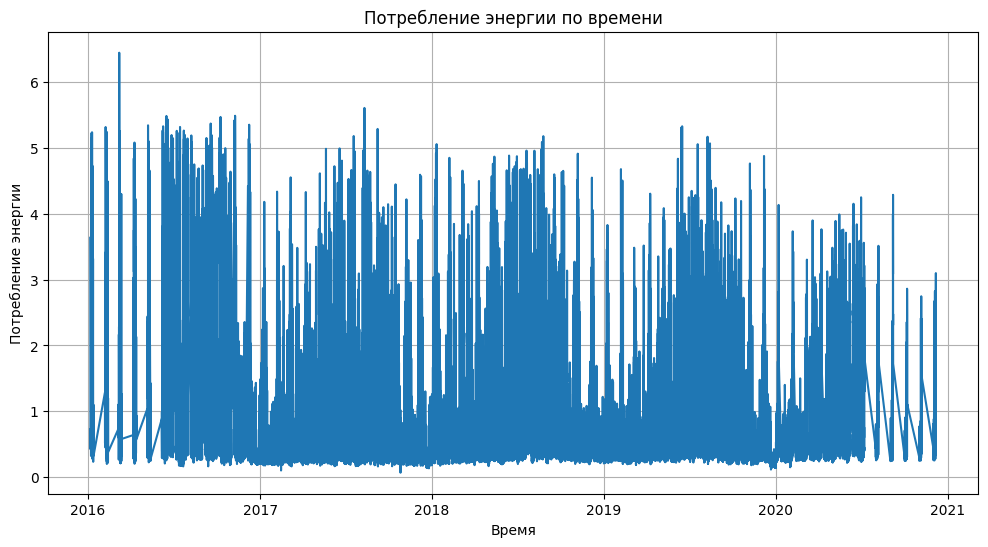

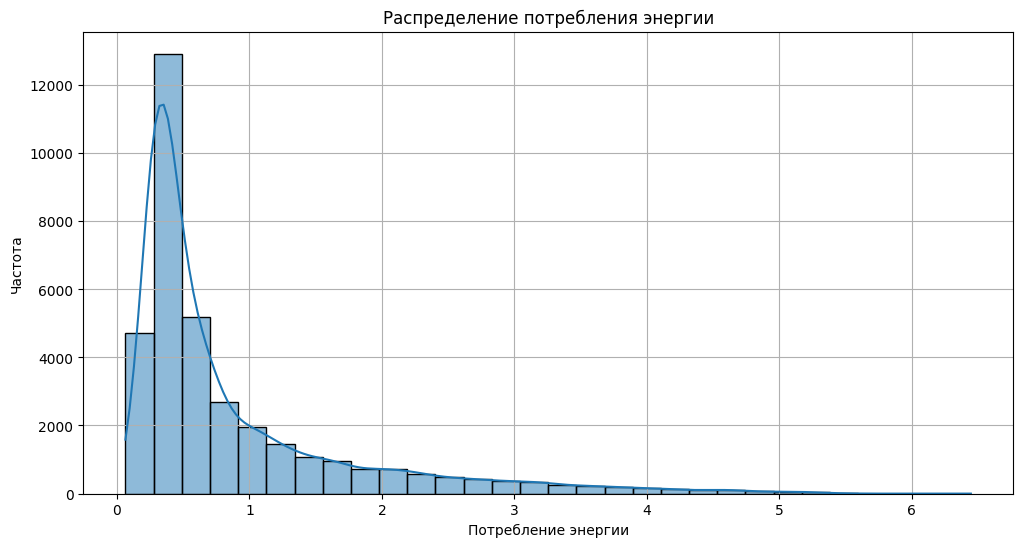

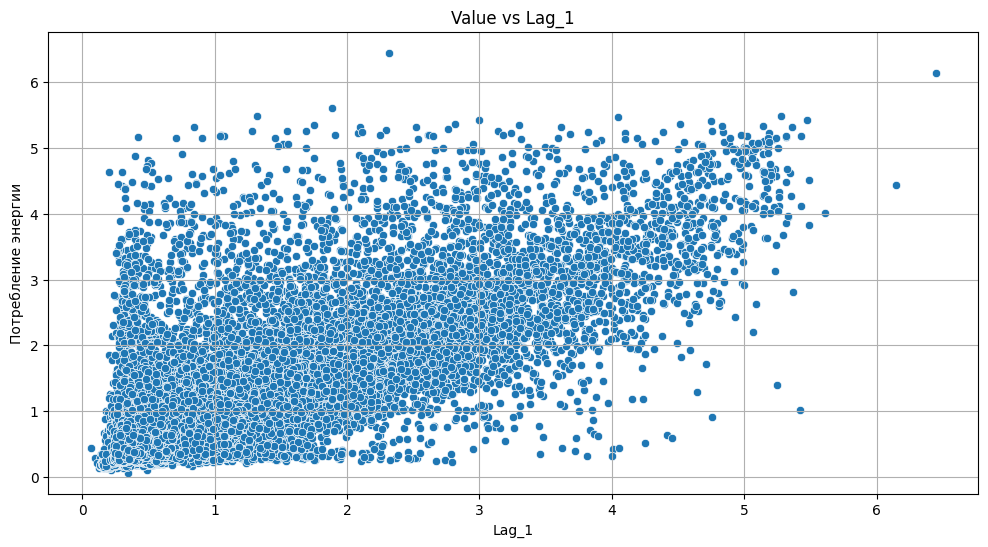

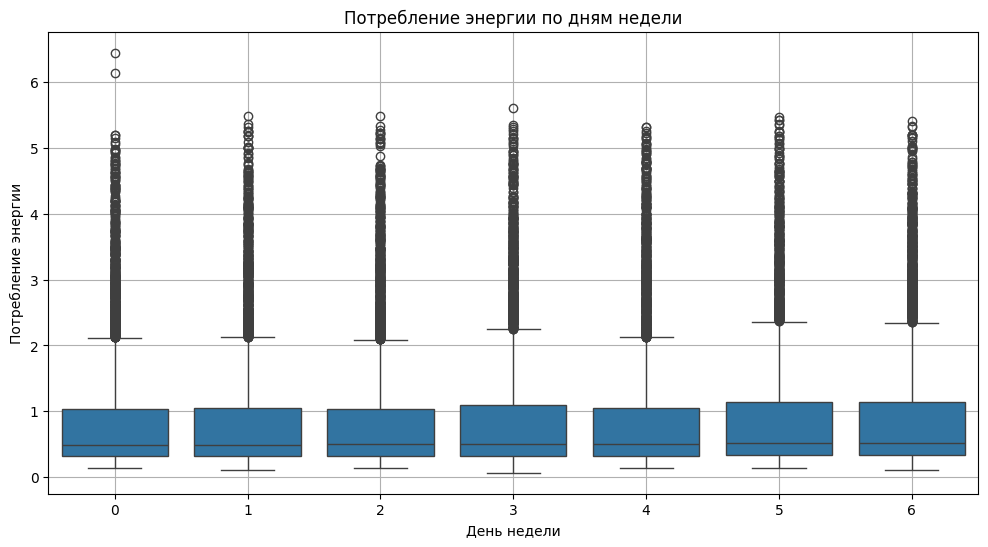

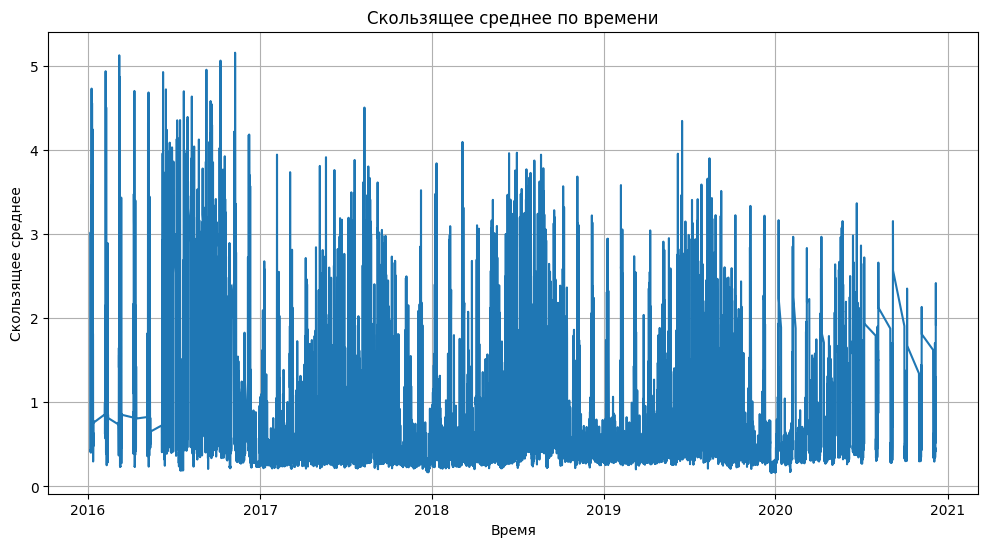

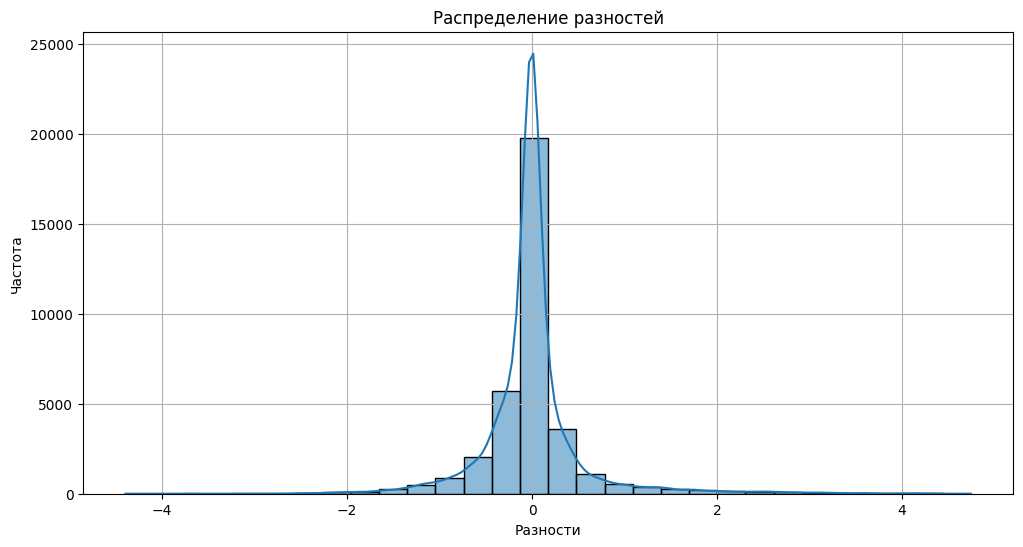

In [49]:

# 1. Линейная диаграмма для потребления энергии
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x=df.index, y='value')
plt.title('Потребление энергии по времени')
plt.xlabel('Время')
plt.ylabel('Потребление энергии')
plt.grid(True)
plt.show()

# 2. Гистограмма для распределения потребления энергии
plt.figure(figsize=(12, 6))
sns.histplot(df['value'], bins=30, kde=True)
plt.title('Распределение потребления энергии')
plt.xlabel('Потребление энергии')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

# 3. Диаграмма рассеяния: value vs lag_1
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df, x='lag_1', y='value')
plt.title('Value vs Lag_1')
plt.xlabel('Lag_1')
plt.ylabel('Потребление энергии')
plt.grid(True)
plt.show()

# 4. Коробчатая диаграмма: value по dayofweek
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='dayofweek', y='value')
plt.title('Потребление энергии по дням недели')
plt.xlabel('День недели')
plt.ylabel('Потребление энергии')
plt.grid(True)
plt.show()

# 5. Линейная диаграмма для скользящего среднего
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x=df.index, y='rolling_window')
plt.title('Скользящее среднее по времени')
plt.xlabel('Время')
plt.ylabel('Скользящее среднее')
plt.grid(True)
plt.show()

# 6. Гистограмма для распределения разностей
plt.figure(figsize=(12, 6))
sns.histplot(df['diff'].dropna(), bins=30, kde=True)
plt.title('Распределение разностей')
plt.xlabel('Разности')
plt.ylabel('Частота')
plt.grid(True)
plt.show()


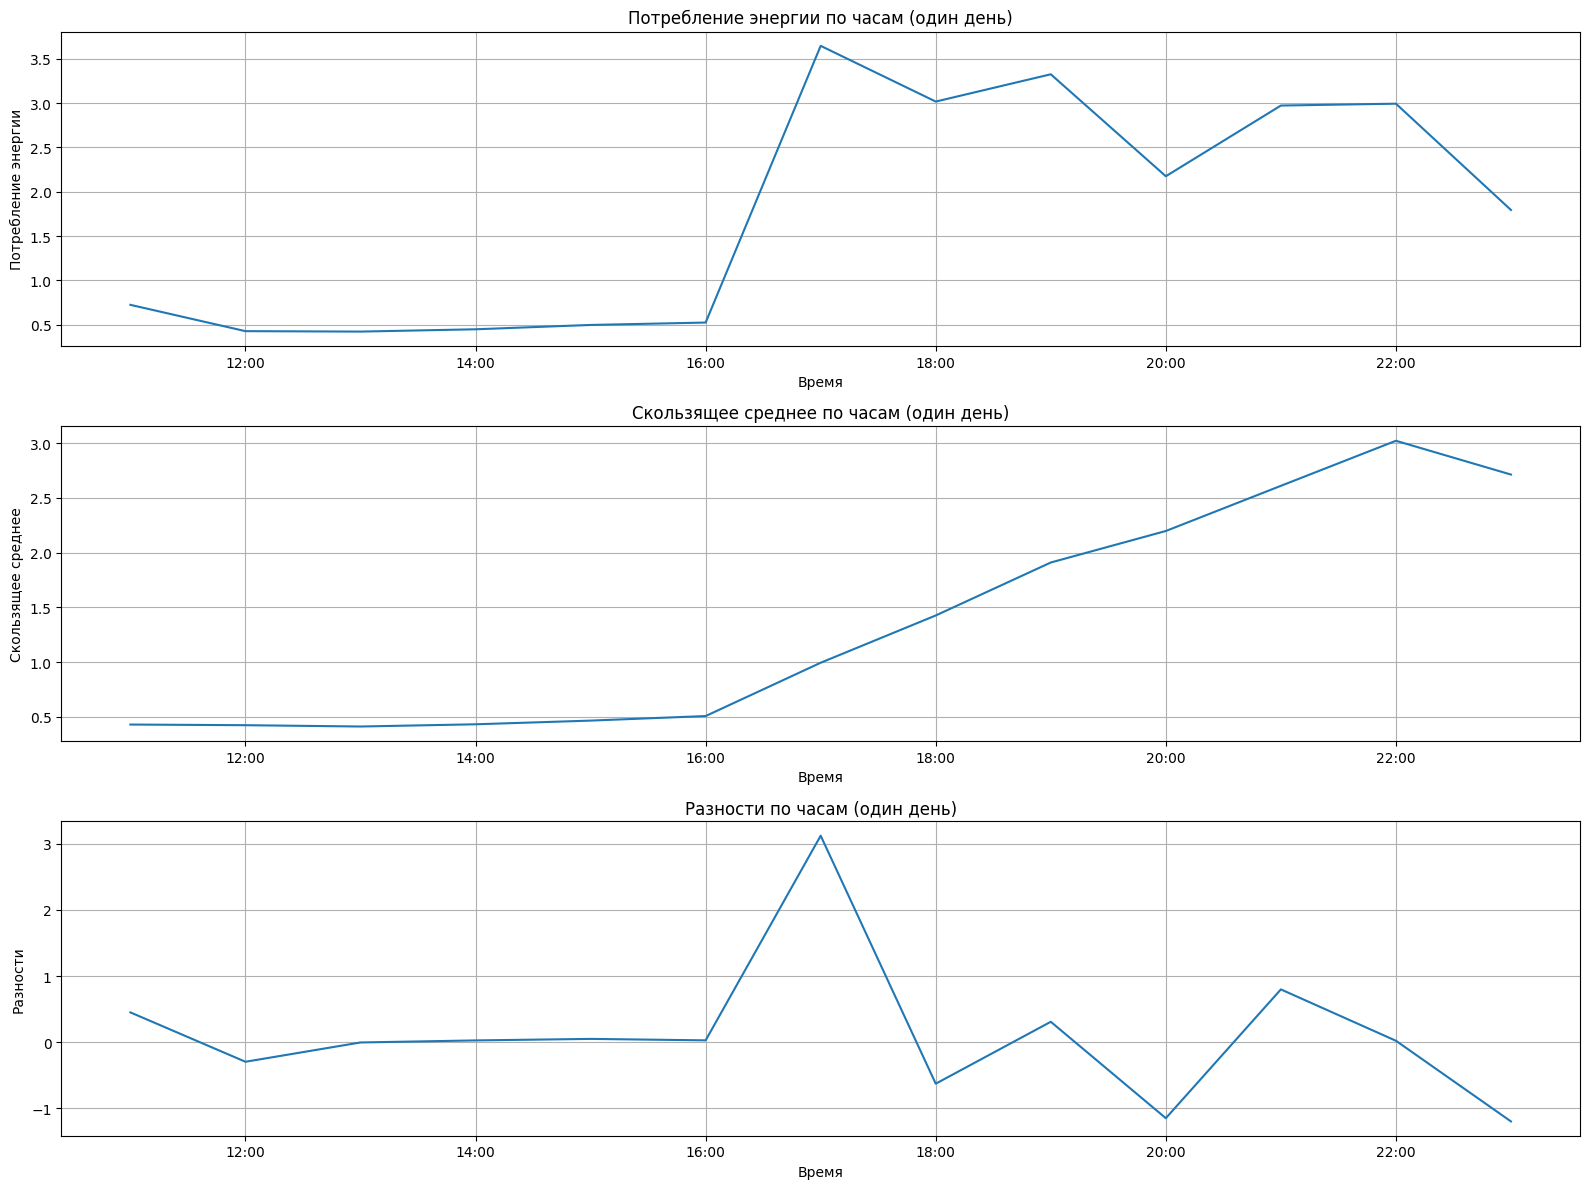

In [50]:
import matplotlib.dates as mdates

# Выберем один день из данных
one_day_data = df.loc['2016-01-06'] # замените на нужную дату

# Построим графики для одного дня
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(16, 12))

# 1. Потребление энергии по часам
sns.lineplot(data=one_day_data, x=one_day_data.index, y='value', ax=axes[0])
axes[0].set_title('Потребление энергии по часам (один день)')
axes[0].set_xlabel('Время')
axes[0].set_ylabel('Потребление энергии')
axes[0].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
axes[0].grid(True)

# 2. Скользящее среднее
sns.lineplot(data=one_day_data, x=one_day_data.index, y='rolling_window', ax=axes[1])
axes[1].set_title('Скользящее среднее по часам (один день)')
axes[1].set_xlabel('Время')
axes[1].set_ylabel('Скользящее среднее')
axes[1].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
axes[1].grid(True)

# 3. Разности (diff)
sns.lineplot(data=one_day_data, x=one_day_data.index, y='diff', ax=axes[2])
axes[2].set_title('Разности по часам (один день)')
axes[2].set_xlabel('Время')
axes[2].set_ylabel('Разности')
axes[2].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
axes[2].grid(True)

plt.tight_layout()
plt.show()


3. Автоматическая генерация признаков с помощью библиотеки tsfresh:

In [ ]:
 
df = pd.read_csv('power_usage_2016_to_2020.csv'
                )
df['StartDate'] = pd.to_datetime(df['StartDate'])
df['date'] = df['StartDate'].dt.date

tsfresh НЕ работает построчно, поэтому нам нужно:
 разбить ряд на объекты (id), например по дням

In [ ]:
df['id'] = df['date'].astype('category').cat.codes

In [ ]:
y = (
    df.groupby('id')['notes']
    .first()
)

y = y.isin(['weekend']).astype(int)

In [ ]:
ts_df = df[['id', 'StartDate', 'Value (kWh)']].rename(
    columns={
        'StartDate': 'time',
        'Value (kWh)': 'value'
    }
)

In [ ]:
ts_df

,id,time,value
0,0,2016-01-06 00:00:00,1.057
1,0,2016-01-06 01:00:00,1.171
2,0,2016-01-06 02:00:00,0.560
3,0,2016-01-06 03:00:00,0.828
4,0,2016-01-06 04:00:00,0.932
...,...,...,...
35947,1467,2020-07-07 19:00:00,1.307
35948,1467,2020-07-07 20:00:00,2.872
35949,1467,2020-07-07 21:00:00,2.138
35950,1467,2020-07-07 22:00:00,2.199


In [ ]:
from tsfresh import extract_features

extracted_features = extract_features(
    ts_df,
    column_id='id',
    column_sort='time'
)

Feature Extraction: 100%|██████████| 30/30 [00:20<00:00,  1.44it/s]


In [ ]:
from tsfresh.utilities.dataframe_functions import impute

impute(extracted_features)


c:\Users\user\Documents\Time_series\venv\Lib\site-packages\tsfresh\utilities\dataframe_functions.py:198: RuntimeWarning: The columns ['value__fft_coefficient__attr_"real"__coeff_13'
 'value__fft_coefficient__attr_"real"__coeff_14'
 'value__fft_coefficient__attr_"real"__coeff_15'
 'value__fft_coefficient__attr_"real"__coeff_16'
 'value__fft_coefficient__attr_"real"__coeff_17'
 'value__fft_coefficient__attr_"real"__coeff_18'
 'value__fft_coefficient__attr_"real"__coeff_19'
 'value__fft_coefficient__attr_"real"__coeff_20'
 'value__fft_coefficient__attr_"real"__coeff_21'
 'value__fft_coefficient__attr_"real"__coeff_22'
 'value__fft_coefficient__attr_"real"__coeff_23'
 'value__fft_coefficient__attr_"real"__coeff_24'
 'value__fft_coefficient__attr_"real"__coeff_25'
 'value__fft_coefficient__attr_"real"__coeff_26'
 'value__fft_coefficient__attr_"real"__coeff_27'
 'value__fft_coefficient__attr_"real"__coeff_28'
 'value__fft_coefficient__attr_"real"__coeff_29'
 'value__fft_coefficient__attr_"re

,value__variance_larger_than_standard_deviation,value__has_duplicate_max,value__has_duplicate_min,value__has_duplicate,value__sum_values,value__abs_energy,value__mean_abs_change,value__mean_change,value__mean_second_derivative_central,value__median,...,value__fourier_entropy__bins_5,value__fourier_entropy__bins_10,value__fourier_entropy__bins_100,value__permutation_entropy__dimension_3__tau_1,value__permutation_entropy__dimension_4__tau_1,value__permutation_entropy__dimension_5__tau_1,value__permutation_entropy__dimension_6__tau_1,value__permutation_entropy__dimension_7__tau_1,value__query_similarity_count__query_None__threshold_0.0,value__mean_n_absolute_max__number_of_maxima_7
0,1.0,0.0,0.0,0.0,29.691,66.014105,0.441783,0.032043,-0.029864,0.6415,...,0.535961,1.031767,2.098147,1.708708,2.507675,2.666149,2.770974,2.890372,0.0,2.846714
1,1.0,0.0,0.0,0.0,43.177,121.837655,0.575826,0.019565,-0.014909,1.4115,...,0.937156,0.937156,1.732659,1.516522,2.120326,2.388890,2.579625,2.736339,0.0,3.599857
2,1.0,0.0,0.0,0.0,50.057,168.111555,0.547087,0.011174,-0.016750,1.3300,...,0.535961,0.937156,1.945935,1.641230,2.532591,2.995732,2.944439,2.890372,0.0,4.410429
3,1.0,0.0,0.0,0.0,47.363,156.864905,0.562391,0.061696,-0.025045,1.1940,...,0.535961,0.793730,1.839297,1.618765,2.466577,2.857103,2.871476,2.890372,0.0,4.321857
4,1.0,0.0,0.0,0.0,42.203,131.200579,0.580087,0.002261,-0.022091,1.2195,...,0.830518,0.937156,2.031759,1.641230,2.466577,2.926418,2.944439,2.890372,0.0,3.910000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1493,0.0,0.0,0.0,0.0,12.087,6.677449,0.154783,-0.004609,-0.002591,0.4610,...,1.265857,1.778233,2.458311,1.708708,2.648438,2.926418,2.944439,2.890372,0.0,0.694429
1494,0.0,0.0,0.0,0.0,16.130,19.418402,0.354087,0.028522,-0.021455,0.3810,...,0.535961,0.535961,1.524707,1.760237,2.846480,2.995732,2.944439,2.890372,0.0,1.419571
1495,0.0,0.0,0.0,1.0,18.011,24.589177,0.347652,0.014870,-0.012136,0.4360,...,0.793730,1.311431,2.351673,1.490692,2.318368,2.787788,2.944439,2.890372,0.0,1.559714
1496,0.0,0.0,0.0,1.0,15.777,15.187809,0.249826,0.005304,-0.013136,0.3980,...,0.793730,1.263626,2.351673,1.744791,2.780466,2.995732,2.944439,2.890372,0.0,1.223571


In [ ]:
y.isna().sum()

np.int64(0)

In [ ]:
from tsfresh import select_features

features_filtered = select_features(extracted_features, y)


In [ ]:
features_filtered

,"value__cwt_coefficients__coeff_6__w_2__widths_(2, 5, 10, 20)","value__cwt_coefficients__coeff_14__w_5__widths_(2, 5, 10, 20)","value__cwt_coefficients__coeff_13__w_5__widths_(2, 5, 10, 20)","value__cwt_coefficients__coeff_7__w_2__widths_(2, 5, 10, 20)","value__cwt_coefficients__coeff_5__w_2__widths_(2, 5, 10, 20)","value__fft_coefficient__attr_""angle""__coeff_1","value__cwt_coefficients__coeff_4__w_5__widths_(2, 5, 10, 20)","value__cwt_coefficients__coeff_5__w_5__widths_(2, 5, 10, 20)","value__cwt_coefficients__coeff_3__w_5__widths_(2, 5, 10, 20)",value__energy_ratio_by_chunks__num_segments_10__segment_focus_4,...,value__ar_coefficient__coeff_10__k_10,"value__cwt_coefficients__coeff_12__w_10__widths_(2, 5, 10, 20)",value__ratio_beyond_r_sigma__r_1,"value__cwt_coefficients__coeff_13__w_10__widths_(2, 5, 10, 20)","value__cwt_coefficients__coeff_8__w_2__widths_(2, 5, 10, 20)",value__index_mass_quantile__q_0.2,"value__cwt_coefficients__coeff_14__w_10__widths_(2, 5, 10, 20)","value__agg_linear_trend__attr_""intercept""__chunk_len_5__f_agg_""var""","value__cwt_coefficients__coeff_14__w_2__widths_(2, 5, 10, 20)",value__quantile__q_0.2
0,-0.145855,-0.658985,-1.621674,-0.275430,0.075835,58.040454,0.629487,0.227585,0.867438,0.005434,...,0.263985,2.587546,0.208333,3.102119,-0.335837,0.375000,3.587833,-0.020360,-1.677654,0.4240
1,-0.166639,3.777167,2.237718,-0.449539,0.196248,94.608859,-0.469397,-1.187346,0.108706,0.090976,...,-1.342746,5.621201,0.458333,6.238209,-0.827923,0.458333,6.762163,0.777859,3.180124,0.5110
2,-0.375218,-0.844420,-2.416598,-0.171387,-0.315117,58.966482,1.241711,0.603118,1.611596,0.009287,...,0.184556,4.628092,0.291667,5.399772,-0.098923,0.333333,6.109826,-0.071504,-2.744348,0.8560
3,0.483685,-1.179884,-2.726128,0.319825,0.387917,57.316911,1.310626,0.762610,1.551115,0.004135,...,-1.241008,4.225793,0.208333,5.012460,-0.114033,0.333333,5.742701,-0.057484,-2.680335,0.5744
4,-0.789311,7.241538,6.947374,-0.576946,-0.881240,154.059231,-2.636327,-2.496406,-2.542112,0.338314,...,-1.006777,8.023860,0.208333,8.332110,-0.784282,0.458333,8.448571,0.508849,4.849802,0.5430
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1493,-0.126946,0.234272,0.169971,0.014623,-0.143825,81.262580,0.443291,0.486111,0.359936,0.045869,...,-0.081533,1.593318,0.250000,1.607201,0.204993,0.250000,1.610329,0.009363,-0.237972,0.3836
1494,-0.434062,-1.000063,-1.148440,-0.776653,0.473461,-7.410799,1.973667,1.740365,1.997803,0.007849,...,-0.245404,1.225807,0.125000,1.179385,-0.678486,0.125000,1.142531,0.377251,-0.184833,0.3100
1495,-0.133842,-0.327805,-0.743939,-0.234733,0.041005,60.357361,0.462704,0.338811,0.492928,0.010727,...,-1.915091,1.827904,0.166667,2.074459,-0.241538,0.333333,2.307787,-0.052522,-0.803429,0.3332
1496,-0.266113,-0.307912,-0.500176,-0.201465,-0.228800,46.896716,0.462690,0.341180,0.521237,0.044121,...,1.689064,1.490268,0.166667,1.650787,-0.129647,0.291667,1.796531,-0.025887,-0.234096,0.3452


4. Исследовать данные датасета power_usage_2016_to_2020 с точки зрения асимметрии и эксцесса:

Подготовка

In [ ]:
x = df['Value (kWh)'].dropna()

In [ ]:
mean = x.mean()
std = x.std(ddof=0)

mu3 = np.mean((x - mean) ** 3)
mu4 = np.mean((x - mean) ** 4)

skewness = mu3 / std**3
kurtosis = mu4 / std**4 - 3

skewness, kurtosis


(np.float64(2.128414253918974), np.float64(4.532479312377308))

In [ ]:
x.skew(), x.kurt()

(np.float64(2.1285030609838027), np.float64(4.533276634742109))

γ₁ > 0 → правосторонняя асимметрия

γ₂ > 0 → островершинное распределение

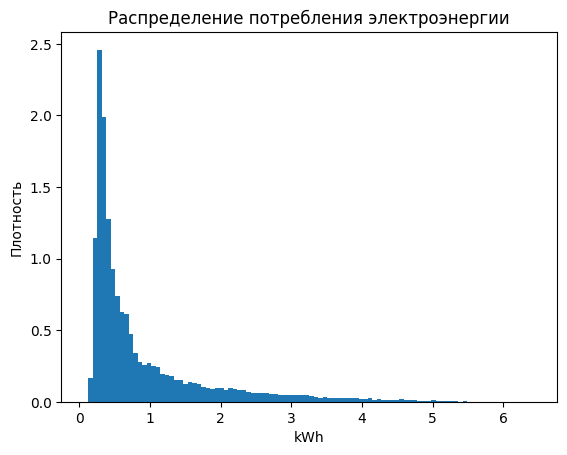

In [ ]:
import matplotlib.pyplot as plt

plt.hist(x, bins=100, density=True)
plt.title("Распределение потребления электроэнергии")
plt.xlabel("kWh")
plt.ylabel("Плотность")
plt.show()


Распределение потребления электроэнергии характеризуется сильной правосторонней асимметрией и высоким положительным эксцессом, что свидетельствует о наличии редких, но значительных пиков нагрузки. Эмпирическое распределение существенно отличается от нормального.

Логарифмическое преобразование (базовое)

In [ ]:

x = df['Value (kWh)'].dropna()
x_log = np.log1p(x)


In [ ]:
mean = x_log.mean()
std = x_log.std(ddof=0)

mu3 = np.mean((x_log - mean)**3)
mu4 = np.mean((x_log - mean)**4)

skew_log = mu3 / std**3
kurt_log = mu4 / std**4 - 3

skew_log, kurt_log


(np.float64(1.3359590799910366), np.float64(0.9645306876558233))

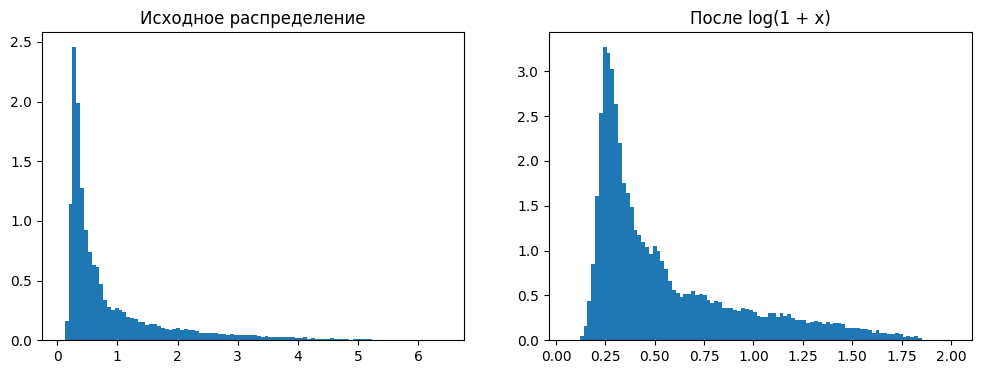

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.hist(x, bins=100, density=True)
plt.title("Исходное распределение")

plt.subplot(1,2,2)
plt.hist(x_log, bins=100, density=True)
plt.title("После log(1 + x)")

plt.show()


Box–Cox (более строгий статистический подход)

In [ ]:
from scipy.stats import boxcox

x_positive = x[x > 0]
x_bc, lambda_bc = boxcox(x_positive)

lambda_bc


np.float64(-0.4888391041493428)

Оптимальное преобразование требует более сильного сжатия больших значений, чем обычное логарифмирование.

Критерий Шапиро–Уилка (Shapiro–Wilk)

In [ ]:
from scipy.stats import shapiro

shapiro(x.sample(5000, random_state=42))
shapiro(x_log.sample(5000, random_state=42))
shapiro(x_bc[:5000])


ShapiroResult(statistic=np.float64(0.9630686150037033), pvalue=np.float64(6.331127909654504e-34))

Гипотеза о нормальном распределении отвергается.

Критерий Андерсона–Дарлинга

In [ ]:
from scipy.stats import anderson

anderson(x, dist='norm')
anderson(x_log, dist='norm')
anderson(x_bc, dist='norm')


AndersonResult(statistic=np.float64(346.11179769971204), critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=np.float64(-0.7271976660785072), scale=np.float64(0.9466055323228331))
 success: True
 message: '`anderson` successfully fit the distribution to the data.')

Нормальность отвергается на любом уровне значимости.

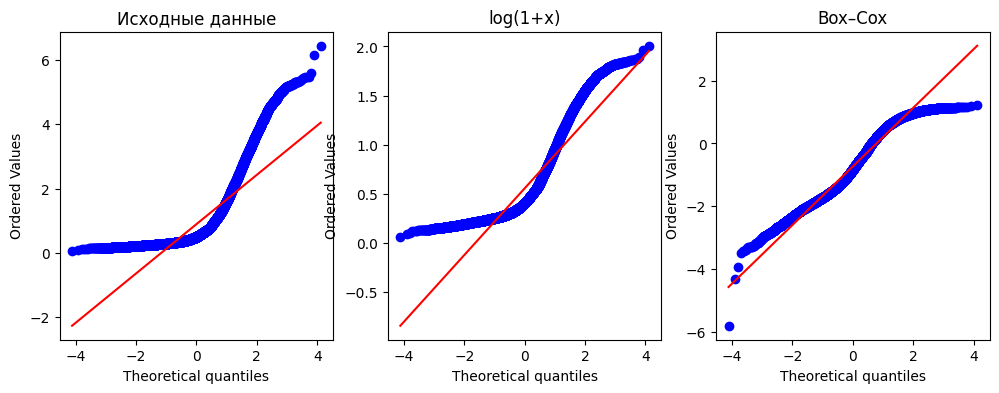

In [ ]:
import scipy.stats as stats
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
stats.probplot(x, plot=plt)
plt.title("Исходные данные")

plt.subplot(1,3,2)
stats.probplot(x_log, plot=plt)
plt.title("log(1+x)")

plt.subplot(1,3,3)
stats.probplot(x_bc, plot=plt)
plt.title("Box–Cox")

plt.show()
